# One vs One Analysis

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import math
import cv2
import gkpose as gk
import ast
import re

In [2]:
mpii_edges = [[0, 1], [1, 2], [2, 6], [6, 3], [3, 4], [4, 5], 
              [10, 11], [11, 12], [12, 8], [8, 13], [13, 14], [14, 15], 
              [6, 8], [8, 9]]

## Import Data

In [3]:
#Import 3D keypoints - set
set_3d_df = pd.read_csv('../1v1Data/set_3d.csv', index_col=0)
set_3d_df = gk.getPhotoID(set_3d_df)

In [4]:
#Import 2D keypoints - set
set_2d_df = pd.read_csv('../1v1Data/set_2d.csv', index_col=0)
set_2d_df = gk.getPhotoID(set_2d_df)

In [5]:
#Import StatsBomb 1v1 Data
converter = {
    'location':ast.literal_eval,
    'shot_end_location':ast.literal_eval,
    'shot_freeze_frame':ast.literal_eval
}
sb_df = pd.read_csv('../StatsBomb/1v1s.csv', index_col=0, converters = converter)

In [6]:
#Get features of each one v one. 
#Can add key pass features later
location_x = []
location_y = []
goalkeeper_x = []
goalkeeper_y = []
striker_distance_to_goal = []
shot_angle = []
gk_engage = []
gk_names = []
for i in range(len(sb_df)):
    shooter_x,shooter_y,_,_,_,_,gk_x,gk_y,is_gk = gk.getFreezeFrame(sb_df, shot_id=i)
    player_names = []
    for p in range(len(sb_df.loc[i,'shot_freeze_frame'])):
        player_names.append(sb_df.loc[i,'shot_freeze_frame'][p]['player']['name'])
    gk_names.append(np.array(player_names)[is_gk.astype(bool)][0])
    location_x.append(shooter_x)
    location_y.append(shooter_y)
    goalkeeper_x.append(gk_x[0])
    goalkeeper_y.append(gk_y[0])
    shot_dist = gk.distance_to_goal(shooter_x, shooter_y)
    striker_distance_to_goal.append(shot_dist) #shot distance to goal
    shot_angle.append(gk.goal_angle(shooter_x, shooter_y)) #shot angle
    gk_striker_dist = gk.distance_to_goal(shooter_x, shooter_y, gk_x[0], gk_y[0])
    gk_engage.append(gk_striker_dist / shot_dist) #Goalkeeper engagement metric
    
#add features to dataframe
sb_df['shooter_x'] = location_x
sb_df['shooter_y'] = location_y
sb_df['goalkeeper_x'] = goalkeeper_x
sb_df['goalkeeper_y'] = goalkeeper_y
sb_df['distance_to_goal'] = striker_distance_to_goal
sb_df['shot_angle'] = shot_angle
sb_df['gk_engage'] = gk_engage
sb_df['gk_name'] = gk_names

#Clean df
sb_df['shot_first_time'] = sb_df['shot_first_time'].fillna(False).astype(int)
sb_df['under_pressure'] = sb_df['under_pressure'].fillna(False).astype(int)
sb_df.loc[sb_df['duration'] > 20, 'duration'] = np.mean(sb_df['duration'])

#Keep only selected features
sb_df = sb_df[['duration','play_pattern_name','under_pressure','shot_outcome_name',
               'shot_first_time','distance_to_goal','shot_angle','gk_name','gk_engage']].copy()

In [7]:
sb_df.head()

,duration,play_pattern_name,under_pressure,shot_outcome_name,shot_first_time,distance_to_goal,shot_angle,gk_name,gk_engage
0,0.240,Regular Play,1,Saved,1,13.453624,48.012788,Danijel Subašić,0.525588
1,0.213,Regular Play,0,Saved,0,14.866069,47.726311,David Ospina Ramírez,0.190261
2,0.667,Regular Play,0,Goal,0,13.892444,30.256437,Wojciech Szczęsny,0.580334
3,0.827,From Counter,0,Goal,0,15.132746,7.594643,Wojciech Szczęsny,0.738818
4,0.453,From Corner,0,Blocked,0,8.062258,60.255119,David Ospina Ramírez,0.447214


In [8]:
set_3d_df.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,file,photo_id
0,-0.187500,0.281250,-0.015079,-0.140625,0.140625,0.169988,-0.046875,-0.015625,-0.012308,0.046875,...,-0.21875,-0.011179,0.203125,-0.093750,0.066936,0.281250,0.000000,0.089892,382-2.png,382
1,0.171875,0.281250,0.033766,0.187500,0.140625,0.152587,0.031250,0.000000,-0.045793,-0.031250,...,-0.21875,0.033514,0.031250,-0.093750,0.138639,0.109375,-0.031250,0.116491,262-2.png,262
2,-0.093750,0.359375,0.016994,0.015625,0.234375,0.005835,-0.031250,0.015625,-0.043475,0.046875,...,-0.15625,-0.072264,0.234375,-0.046875,-0.004875,0.281250,0.062500,-0.011386,537-2.png,537
3,-0.156250,0.390625,-0.044468,-0.140625,0.171875,0.159150,-0.046875,0.000000,-0.028738,0.062500,...,-0.34375,-0.019926,0.234375,-0.234375,0.068202,0.359375,-0.140625,0.027107,476-2.png,476
4,-0.125000,0.406250,-0.001968,-0.125000,0.203125,0.166595,-0.062500,0.000000,-0.005656,0.078125,...,-0.28125,-0.014175,0.140625,-0.234375,0.037226,0.140625,-0.109375,0.019169,63.png,63


In [9]:
#Merge set_3d_df (file) with sb_df (index)
set_3d_df = set_3d_df.merge(sb_df, left_on='photo_id', right_index=True, how='left')
set_2d_df = set_2d_df.merge(sb_df, left_on='photo_id', right_index=True, how='left')

In [10]:
set_3d_df.head()

,0,1,2,3,4,5,6,7,8,9,...,photo_id,duration,play_pattern_name,under_pressure,shot_outcome_name,shot_first_time,distance_to_goal,shot_angle,gk_name,gk_engage
0,-0.187500,0.281250,-0.015079,-0.140625,0.140625,0.169988,-0.046875,-0.015625,-0.012308,0.046875,...,382,0.186800,From Free Kick,0,Saved,0,7.280110,74.054604,Jonas Lössl,0.566352
1,0.171875,0.281250,0.033766,0.187500,0.140625,0.152587,0.031250,0.000000,-0.045793,-0.031250,...,262,0.454694,From Throw In,1,Goal,0,11.180340,63.434949,Hugo Lloris,0.644981
2,-0.093750,0.359375,0.016994,0.015625,0.234375,0.005835,-0.031250,0.015625,-0.043475,0.046875,...,537,0.771300,From Throw In,0,Goal,0,11.313708,45.000000,Mathew Ryan,1.000000
3,-0.156250,0.390625,-0.044468,-0.140625,0.171875,0.159150,-0.046875,0.000000,-0.028738,0.062500,...,476,0.714875,Regular Play,0,Saved,0,12.041595,4.763642,Tom Heaton,0.332182
4,-0.125000,0.406250,-0.001968,-0.125000,0.203125,0.166595,-0.062500,0.000000,-0.005656,0.078125,...,63,0.533000,From Free Kick,0,Goal,1,8.485281,45.000000,Eiji Kawashima,0.687184


In [11]:
sets_3d = set_3d_df.loc[:,'0':'47'].values
print(sets_3d.shape)

(590, 48)


In [12]:
sets_2d = set_2d_df.loc[:,'0':'31'].values
print(sets_2d.shape)

(590, 32)


In [13]:
np.where(set_3d_df['photo_id'] == 454)[0]

array([ 62,  90, 416])

## Camera-view Invariant Dataset

In [14]:
#Get camera-view invariant dataset of 3d poses
sets_3d_cvi = gk.cameraInvariantDataset(sets_3d)

In [15]:
sets_3d_cvi.shape

(590, 48)

In [16]:
#Create the cvi sets dataframe
set_3d_cvi_df = pd.DataFrame(sets_3d_cvi)
set_3d_cvi_df.columns = set_3d_cvi_df.columns.astype(str)
cols = ['file', 'photo_id', 'duration', 'play_pattern_name', 'under_pressure',
       'shot_outcome_name', 'shot_first_time', 'distance_to_goal',
       'shot_angle', 'gk_name', 'gk_engage']
set_3d_cvi_df[cols] = set_3d_df[cols]

In [17]:
#Create cvi set array with gk_engage metric included
keep_cols = np.array(list(range(48)) + ['gk_engage'])
sets_3d_cvi = set_3d_cvi_df.loc[:,keep_cols].values
print(sets_3d_cvi.shape)

(590, 49)


In [18]:
set_3d_cvi_df.head()

,0,1,2,3,4,5,6,7,8,9,...,photo_id,duration,play_pattern_name,under_pressure,shot_outcome_name,shot_first_time,distance_to_goal,shot_angle,gk_name,gk_engage
0,-0.187270,0.281250,0.017709,-0.108971,0.140625,0.191825,-0.048300,-0.015625,-0.003981,0.047579,...,382,0.186800,From Free Kick,0,Saved,0,7.280110,74.054604,Jonas Lössl,0.566352
1,0.084613,0.281250,0.153368,0.003635,0.140625,0.241714,0.055167,0.000000,-0.005496,-0.049572,...,262,0.454694,From Throw In,1,Goal,0,11.180340,63.434949,Hugo Lloris,0.644981
2,-0.047243,0.359375,0.082741,0.014513,0.234375,-0.008219,-0.053391,0.015625,-0.004006,0.063689,...,537,0.771300,From Throw In,0,Goal,0,11.313708,45.000000,Mathew Ryan,1.000000
3,-0.157551,0.390625,0.039614,-0.042210,0.171875,0.208141,-0.054964,0.000000,-0.001450,0.065672,...,476,0.714875,Regular Play,0,Saved,0,12.041595,4.763642,Tom Heaton,0.332182
4,-0.125000,0.406250,-0.001968,-0.125000,0.203125,0.166595,-0.062500,0.000000,-0.005656,0.078125,...,63,0.533000,From Free Kick,0,Goal,1,8.485281,45.000000,Eiji Kawashima,0.687184


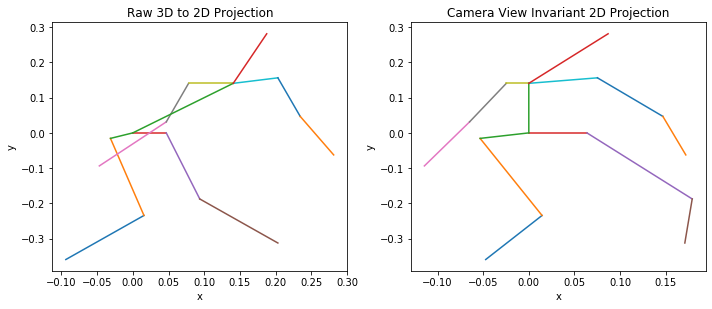

In [25]:
pose_id = 2
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(2, 2, 1)
gk.plot2D(ax, gk.pose_to_matrix(sets_3d[pose_id]), mpii_edges)
ax.set_title('Raw 3D to 2D Projection')
ax = fig.add_subplot(2, 2, 2)
gk.plot2D(ax, gk.pose_to_matrix(sets_3d_cvi[pose_id][:-1]), mpii_edges)
ax.set_title('Camera View Invariant 2D Projection')
plt.tight_layout()
plt.show()

## Remove Bad Pose Predictions

Array ID: 1
File Name: 262-2.png


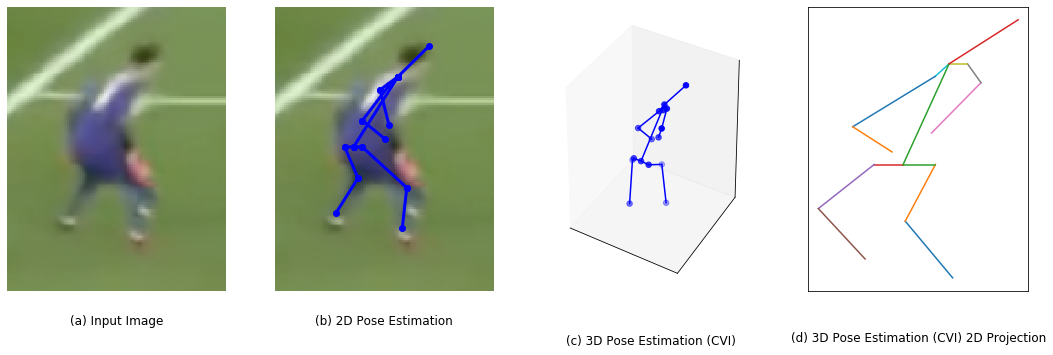

In [19]:
array_id = 1
gk.plot2D3DPose(array_id, set_3d_df, sets_2d, sets_3d_cvi, '../1v1Data/set/', mpii_edges)

In [26]:
#List of the array_ids in which to remove because they are bad prediction of true pose
#Removed based on the CVI 2D projection
to_remove_sets = np.array([1,6,7,11,14,25,27,28,31,32,37,40,42,43,44,51,52,53,55,58,
                           63,65,72,81,83,85,87,94,96,108,109,110,113,114,116,117,119,
                           123,131,133,135,136,137,140,141,143,144,147,150,151,154,156,
                           157,159,160,161,163,167,170,176,189,193,195,196,198,200,
                           202,203,206,207,210,211,213,216,217,218,220,227,228,235,
                           237,238,242,243,244,245,250,251,252,255,261,262,267,268,
                           270,271,274,275,276,282,287,291,296,297,298,304,305,311,312,
                           316,320,323,324,326,327,328,333,334,335,341,350,351,352,370,
                           372,374,379,387,388,389,390,395,397,401,406,411,413,414,418,
                           419,423,433,436,439,443,446,451,452,453,456,462,465,470,472,
                           474,475,480,489,490,494,502,507,509,515,517,522,528,532,533,
                           537,553,555,558,566,567,570,572,575,579,580,585,])
print("Removing " + str(len(to_remove_sets)) + " of " + 
      str(len(sets_3d_cvi)) + " poses, " + str(100*np.round(len(to_remove_sets)/len(sets_3d_cvi), 2)) + "%")

Removing 181 of 590 poses, 31.0%


## Visualisations / Analysis

<IPython.core.display.Javascript object>


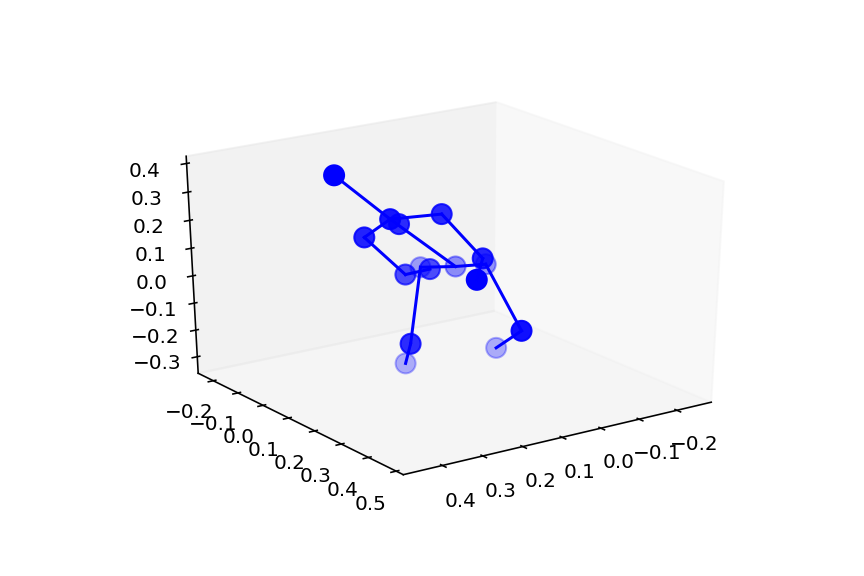

In [70]:
%matplotlib notebook
points = gk.pose_to_matrix(sets_3d[189])
fig = plt.figure()
ax = fig.add_subplot((111),projection='3d')
gk.plot3D(ax, points, edges=mpii_edges)
plt.show()

## Unsupervised Learning

In [125]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

In [126]:
def silhouetteInertia(poses):
    #Silhouette scores and inertia to find optimal number of clusters, k
    silhouette = []
    inertia = []
    for k in range(2, 11):
        kmeans = KMeans(n_clusters=k)
        clusters = kmeans.fit_predict(poses)
        silhouette.append(silhouette_score(poses, clusters))
        inertia.append(kmeans.inertia_)
    return (silhouette, inertia)

In [127]:
sil, iner = silhouetteInertia(sets_3d_cvi)

In [128]:
sil

[0.2839485213831102,
 0.293254342019534,
 0.22130682684280117,
 0.2245532266867677,
 0.2268120472807054,
 0.11848137716237216,
 0.10552572269631282,
 0.08820429835321944,
 0.09229222963506604]

In [129]:
def getKMeans(poses, k):
    kmeans = KMeans(n_clusters=k)
    clusters_kmeans = kmeans.fit_predict(poses)
    return clusters_kmeans

In [130]:
k=3
clusters_2d = getKMeans(sets_3d_cvi, k=k)

In [162]:
print(set_2d_df['file'][0])
print(set_2d_df['file'][1])
print(set_2d_df['file'][2])
print(set_2d_df['file'][4])
print(set_2d_df['file'][5])
print(set_2d_df['file'][6])

382-2.png
262-2.png
537-2.png
63.png
88.png
176.png


In [168]:
print(set_2d_df['file'][512])
print(set_2d_df['file'][518])
print(set_2d_df['file'][539])
print(set_2d_df['file'][564])
print(set_2d_df['file'][581])
print(set_2d_df['file'][582])

498-3.png
41.png
92.png
251-2.png
522-3.png
357-3.png


In [140]:
#Get photo id's of poses in cluster x
np.array(set_3d_cvi_df.loc[np.where(clusters_2d == 1)[0], 'photo_id'])

array([262, 323, 406, 348, 437,  75, 380, 431, 367, 474, 318, 185,  60,
        65, 437, 388, 439, 349, 375, 148, 323,  76, 188, 262, 246, 201,
       102, 490, 324, 429, 295, 470, 318,  10, 494, 139, 212, 138, 164,
       457, 362, 178, 305, 428, 502, 490, 517, 325, 204, 533, 362, 239,
       490, 183, 242, 386,  99, 177, 173, 384, 102, 263, 453, 458, 470,
       464, 114, 262, 381, 414, 538, 504, 510, 179, 101, 245, 459, 142,
       107, 243, 283, 311, 305, 473, 416, 103, 117, 477, 367, 455, 378,
       500, 121,  39, 361, 110, 460, 345, 468, 312, 474, 310, 497, 412,
       457, 502, 267, 294, 438, 459, 171,  35, 421, 487, 356, 313, 313,
       461, 307, 449, 138, 239,  38, 267, 501, 490, 447, 309, 390, 323,
       313, 445, 486, 349, 235, 121, 464, 459, 525, 243, 245, 446, 522,
       536, 486, 318, 456, 330, 356, 313, 237, 197,  37, 482, 240, 283,
       482, 247, 521, 444, 114, 538,  30, 290, 496, 418, 327, 313, 457,
       486, 494, 337, 132, 462, 502, 341, 440, 326, 468, 521, 48

In [132]:
from sklearn.manifold import TSNE
tsne_embedded = TSNE(n_components=2).fit_transform(sets_3d_cvi)

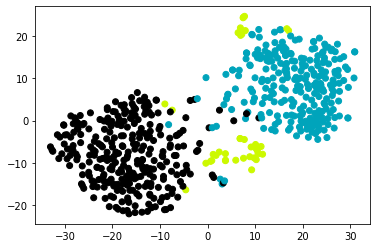

In [133]:
colors_kmeans = cm.nipy_spectral(clusters_2d.astype(float) / k)
plt.scatter(tsne_embedded[:,0], tsne_embedded[:,1], c=colors_kmeans)
plt.show()

In [114]:
tsne_embedded[17]

array([  7.8216095, -27.126472 ], dtype=float32)

In [134]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit_transform(sets_3d_cvi)

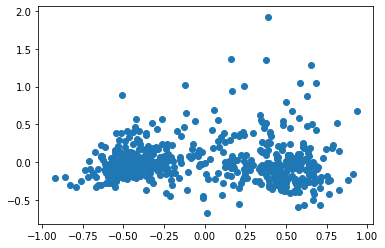

In [135]:
plt.scatter(pca[:,0], pca[:,1])
plt.show()

In [ ]:
pca[[26, 25]]